# Stochastic Optimization

## 2.2 CMA Evolutionary Strategy

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

# CMA-ES

In this section, we'll discuss the Covariance Matrix Adaptation Evolutionary Strategy, or CMA-ES [1, 2]. This is one of the most well-known evolutionary algorithms in general and is a state-of-the-art algorithm for continuous optimization. The strength of this method is that it adapts the distribution it uses to generate the next population based on the current distribution of individuals. In the previous section, we were limited to a Normal distribution with a static $\sigma$. The adaptive distribution of CMA-ES means it will cross search spaces faster and narrow in more exactly on optimal points.

[1] Hansen, Nikolaus, and Andreas Ostermeier. "Adapting arbitrary normal mutation distributions in evolution strategies: The covariance matrix adaptation." Proceedings of IEEE international conference on evolutionary computation. IEEE, 1996.

[2] Hansen, Nikolaus, and Andreas Ostermeier. "Completely derandomized self-adaptation in evolution strategies." Evolutionary computation 9.2 (2001): 159-195.

Specifically, the things that CMA-ES improves over the previous Evolutionary Strategies we've seen is that it:
+ combines information from multiple individuals
+ combines information from multiple generations
+ transforms the distribution of the new population to match the search space
+ adapts the step size to prevent premature convergence

CMA-ES uses two principles to achieve this: maximum likelihood estimation and step-size control. We'll start with maximum likelihood estimation, which consists of increasing the probability of successful points. CMA-ES will update the population center by taking the weighted average of high-fitness individuals.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math

In [6]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [7]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)

In [8]:
lam = 70
x = np.random.rand(2) * 4 - 2
N = np.random.normal(size=(lam,2))
x_t = x + N
fits = himmelblau(x_t[:, 0], x_t[:, 1])

First, we select the top $\mu$ individuals based on their fitness values. We'll then weight their importance by their fitness rank, using a static weight vector $w$. This weight vector $w$ is a hyperparameter in CMA-ES, but there is a standard normalized logarithmic weight scale used by most. Note that the weight is not their fitness values but rather just the rank. This has been demonstrated to aid in search in ill-formed search spaces.

In [9]:
mu = 10
sorted_ids = np.argsort(fits)
w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
w /= np.sum(w)
weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
s = np.mean(weighted, axis=0)
s

array([-0.1901101 , -0.06706574])

This $s$ direction vector is similar to the gradient estimation from the last exercise. However, in CMA-ES, only the top $\mu$ individuals are used to calculate $s$, and instead of directly using fitness values, $s$ is calculated using weight based on fitness rank. We can compare the two vectors.

In [10]:
A = (fits - np.mean(fits)) / np.std(fits)
G = -np.dot(A, N) / lam

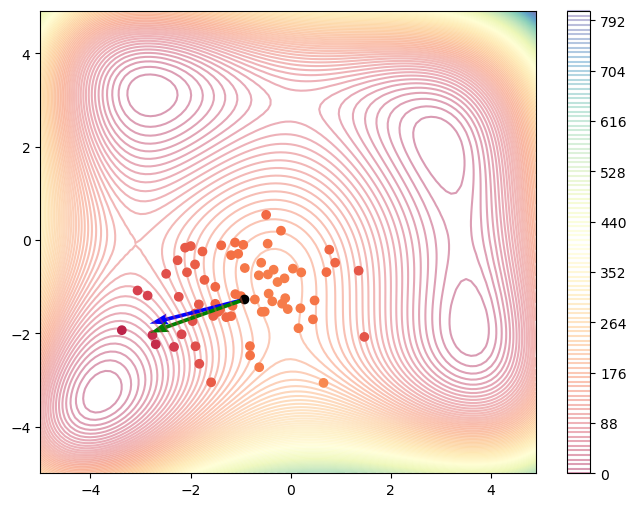

In [11]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(x_t[:, 0], x_t[:, 1], c=fits, cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1], color='b', scale=4)
plt.quiver(x[0], x[1], s[0], s[1], color='g', scale=1)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

While we're only using the fitness information for a ranked weighting, this direction vector $s$ can be seen as a gradient approximation. As before, we can use this gradient information to update the center of our distribution. This is the first step of maximum likelihood estimation, aligning the distribution center with the weighted average of the best solutions.

In [ ]:
x = x + s

A fundamental idea behind CMA-ES is to estimate the covariance between the selected samples, and to use this covariance matrix to shape the next distribution. A covariance matrix measures the joint variability between the different dimensions of the objective function. Covariance matrices are outside of the scope of this class, but this article has more details:
https://datascienceplus.com/understanding-the-covariance-matrix/

We start CMA-ES with the identity matrix as the initial covariance matrix, assuming each variable is independent and has a standard deviation of 1.

In [ ]:
C = np.eye(2)
C

At each step, we update $C = C + ss^T$. This will use the weighted sample average as an estimate of the covariance. In CMA-ES, it is referred to as the rank one covariance update. For problems of higher dimension, there is an additional matrix update.

In [ ]:
C = C + np.outer(s, (s).T)
C

The eigen decomposition of the covariance matrix is then used to transform the Normal distribution to match the search space. This is the second part of maximum likelihood estimation: by pulling samples from a distribution fit to performant parts of the search space, there is a higher chance of sampling good individuals. The mean of the distribution $x$ and the shape given by $C$ together maximize this likelihood.

In [ ]:
N = np.random.normal(size=(lam, 2))
x_N = x + N
eigenvalues, eigenvectors = np.linalg.eig(C)
x_C = x + np.array([np.dot(eigenvectors, np.sqrt(eigenvalues) * N[i, :]) for i in range(lam)])

In [ ]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(x_N[:, 0], x_N[:, 1], c='k', alpha=0.3)
plt.scatter(x_C[:, 0], x_C[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs)
plt.show()

The second main feature in CMA-ES besides maximum likelihood estimation is step-size control. CMA-ES updates two different step size parameters at different time constants. The first is the update we did previously, the update to the covariance matrix. The common formula for this is

$C = (1 - c_i)C + c_i s s^T$

where $c_i$ is the rank one covariance matrix update learning rate. $c_i = 2/n^2$ where $n$ is the number of dimensions is a default parameter.

The other step size parameter comes in the update to the standard deviation $\sigma$. Until now, we've assumed that $\sigma = 1$, but in CMAES, $\sigma$ updates at each time step.

An effect of these two different updates, which are often referred to as two "evolutionary paths", is that CMA-ES will continue to search even after finding a local optima. $\sigma$ updates faster than $C$, narrowing in on selected areas or expanding on others, while the shape of the sampled distribution is refined over time.

The full details of the step size updates are beyond the scope of this class, but I recommend my spring elective class for further details on CMA-ES (https://d9w.github.io/evolution/5_strategies/) or Scholarpedia which offers a simplified CMA-ES version [3].

[3] Hans-Georg Beyer (2007) Evolution strategies. Scholarpedia, 2(8):1965.

<img src="imgs/cmaes.png">

To see CMA-ES in practice, we'll use the pycma package (https://github.com/CMA-ES/pycma). If you haven't installed it, do `pip install cma`. pycma is maintained by the CMA-ES author and has many more algorithm tricks and features than we've discussed here. [4] provides a good review of different CMA-ES modifications.

[4] Hansen, Nikolaus. "The CMA evolution strategy: a comparing review." Towards a new evolutionary computation. Springer, Berlin, Heidelberg, 2006. 75-102.

In [ ]:
import cma
es = cma.CMAEvolutionStrategy(2 * [0], 0.1, {'popsize': 20, 'verb_disp': 1})

In [ ]:
solutions = np.array(es.ask())
es.tell(solutions, [himmelblau(x[0], x[1]) for x in solutions])
es.disp_annotation()
es.disp();

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(solutions[:, 0], solutions[:, 1])
fig.colorbar(cs)
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML, display

def generation(i, es, ax):
    solutions = np.array(es.ask())
    es.tell(solutions, [himmelblau(x[0], x[1]) for x in solutions])
    
    ax.clear()
    ax.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
    ax.scatter(solutions[:, 0], solutions[:, 1])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.plot()

fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
fig.tight_layout()
es = cma.CMAEvolutionStrategy(2 * [0], 0.1, {'popsize': 20})

frames = 20
animator = animation.FuncAnimation(fig, generation, fargs=(es, ax), frames=frames, interval=250, blit=False)
display(HTML(animator.to_html5_video()))
plt.close();

Most of CMA-ES hyperparameters have been well studied to provide reasonable default values. While we used 20 above for illustration, the default population size or $\lambda = 4+\lfloor3\log(N)\rfloor$, where $N$ is the number of dimensions.

<div class="alert alert-success">
    <h3>Exercise 3</h3>
        
Following the [documentation](https://pypi.org/project/cma/) of pycma, use CMA-ES on the Rosenbrock function. Experiment with the number of dimensions of the problem and the population size. Is $\lambda = 4+\lfloor3\log(N)\rfloor$ the best value?
</div>

<div class="alert alert-success">
    <h3>Exercise 4</h3>
    
CMA-ES has been widely used in many applications. Discuss one of the following application papers in your group. What is the application? How is the problem encoded in a way that CMA-ES can solve it? Is CMA-ES compared to other methods and if so, how does it do?
    
+ Gagné, C., Beaulieu, J., Parizeau, M., & Thibault, S. (2008). Human-competitive lens system design with evolution strategies. Applied Soft Computing, 8(4), 1439-1452.
+ Bayer, P., & Finkel, M. (2007). Optimization of concentration control by evolution strategies: Formulation, application, and assessment of remedial solutions. Water resources research, 43(2).
+ Kämpf, J. H., & Robinson, D. (2009). A hybrid CMA-ES and HDE optimisation algorithm with application to solar energy potential. Applied Soft Computing, 9(2), 738-745.
+ Maki, A., Sakamoto, N., Akimoto, Y., Nishikawa, H., & Umeda, N. (2020). Application of optimal control theory based on the evolution strategy (CMA-ES) to automatic berthing. Journal of Marine Science and Technology, 25(1), 221-233.
+ Loshchilov, I., & Hutter, F. (2016). CMA-ES for hyperparameter optimization of deep neural networks. arXiv preprint arXiv:1604.07269.
+ Fukagata, K., Kern, S., Chatelain, P., Koumoutsakos, P., & Kasagi, N. (2008). Evolutionary optimization of an anisotropic compliant surface for turbulent friction drag reduction. Journal of Turbulence, (9), N35.
</div>

<div class="alert alert-info">
    <h3>Bonus Exercise</h3>
    
Compare CMA-ES to a previous algorithm, either random search, simulated annealing, or one of the evolutionary strategies on the Rosenbrock function. Try a different BBOB [function](http://cma.gforge.inria.fr/apidocs-pycma/classIndex.html#cma.bbobbenchmarks.BBOBFunction) (full function explanations [here](https://coco.gforge.inria.fr/downloads/download16.00/bbobdocfunctions.pdf#page=5)).
</div>